<a href="https://colab.research.google.com/github/Guru2308/Deep-Learning-with-PyTorch/blob/main/rspd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing necessary libraries and modules for this notebook<a name ="h3"></a>

In [1]:

'''Data Handling & Linear Algebra'''
import numpy as np
import pandas as pd

'''Visualisation'''
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams
import seaborn as sns

'''Data Analysis'''
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

'''Manipulating Data and Model Building'''
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import GlobalMaxPooling2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Add
from keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DIR_TRAIN_IMAGES = "/content/drive/MyDrive/Solar_Panel_Data/training/"
DIR_TRAIN_LABELS = "/content/drive/MyDrive/Solar_Panel_Data/labels_training.csv"

#Exploratory Analysis & Data Scaling<a name ="h4"></a>




In [4]:
pd.read_csv(DIR_TRAIN_LABELS).head()

,id,label
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1


In [5]:
def load_data(dir_data, dir_labels):
    '''
    dir_data: Data directory
    dir_labels: Respective csv file containing ids and labels
    returns: Array of all the image arrays and its respective labels
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids = labels_pd.id.values
    data = []
    for identifier in ids:
        fname = dir_data + identifier.astype(str) + '.tif'
        image = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data)
    labels = labels_pd.label.values
    return data, labels

In [6]:
X, y = load_data(DIR_TRAIN_IMAGES, DIR_TRAIN_LABELS)

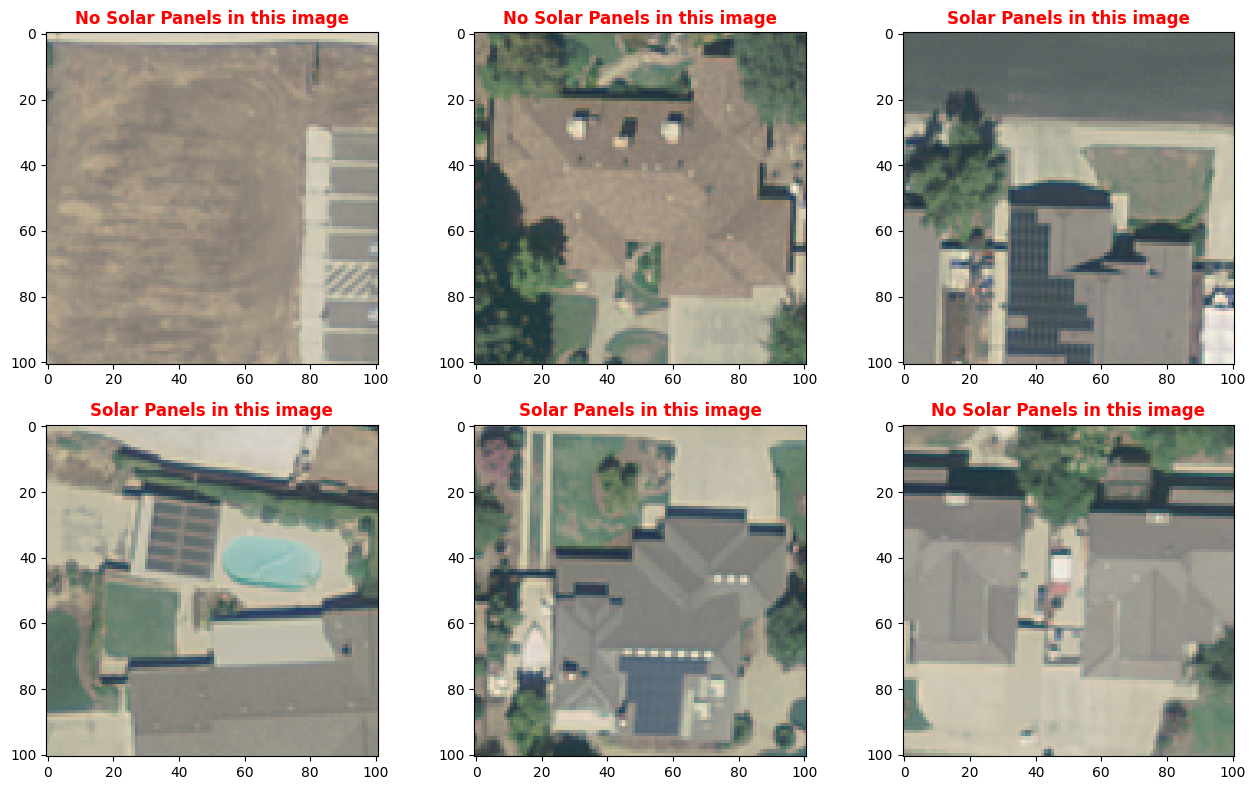

In [7]:
plt.figure(figsize = (13,8))
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.imshow(X[i])
  if y[i] == 0:
    title = 'No Solar Panels in this image'
  else:
    title = 'Solar Panels in this image'
  plt.title(title, color = 'r', weight = 'bold')
plt.tight_layout()
plt.show()

In [8]:
print('X shape:\n', X.shape)

X shape:
 (1500, 101, 101, 3)


In [9]:
print('Distribution of y', np.bincount(y))

Distribution of y [995 505]


In [10]:
X = X / 255.0

In [11]:
def build_model():
    '''
    Returns a Keras CNN model
    '''

    IMAGE_HEIGHT = 101
    IMAGE_WIDTH = 101
    IMAGE_CHANNELS = 3

    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=3,
                     activation='relu',
                     input_shape=(IMAGE_HEIGHT,
                                  IMAGE_WIDTH,
                                  IMAGE_CHANNELS)))

    model.add(BatchNormalization())


    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())


    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=2))


    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())


    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())


    model.add(MaxPooling2D(pool_size=2))


    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())


    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())


    model.add(GlobalMaxPooling2D())

    model.add(Dense(1, activation='sigmoid'))


    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


##Checking the Performance of our CNN Model

In [12]:
def cv_performance_assessment(X, y, num_folds, clf, random_seed=1):
    '''
    Cross validated performance assessment

    Input:
        X: training data
        y: training labels
        num_folds: number of folds for cross validation
        clf: classifier to use

    Divide the training data into k folds of training and validation data.
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are
    aggregated and output.
    '''

    prediction_scores = np.empty(y.shape[0], dtype='object')


    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

    for train_index, val_index in kf.split(X, y):

        X_train, X_val = X[train_index], X[val_index]
        y_train = y[train_index]

        class_weight = {0: 505/1500, 1: 995/1500}

        # train the classifier
        training = clf.fit(x=X_train,
                           y=y_train,
                           class_weight=class_weight,
                           batch_size=32,
                           epochs=1 ,
                           shuffle=True,
                           verbose=1)

        # test the classifier on the validation data for this fold
        y_val_pred_probs = clf.predict(X_val).reshape((-1, ))

        # save the predictions for this fold
        prediction_scores[val_index] = y_val_pred_probs

    return prediction_scores

In [13]:
num_folds = 3

random_seed = 1

cnn = build_model()

cnn.summary()

cnn_y_hat_prob = cv_performance_assessment(X, y, num_folds, cnn, random_seed=random_seed)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 99, 99, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 99, 99, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 97, 97, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 95, 95, 128)       73856     
                                                                 
 batch_normalization_2 (Batc  (None, 95, 95, 128)      5

Looking at the True Positives, False Negatives, False Positives & True Negatives -



In [14]:
df = pd.read_csv(DIR_TRAIN_LABELS)
df["predicted_score"] = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_prob]

fn = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 0)]['id'])
fp = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 1)]['id'])
tp = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 1)]['id'])
tn = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 0)]['id'])

In [15]:
def show_images(image_ids, num_images, title, color):
    '''
    Display a subset of images from the image_ids data
    '''
    rcParams['figure.figsize'] = 20, 4
    plt.figure()
    n = 1
    for i in image_ids[0:num_images]:
        plt.subplot(1, num_images, n)
        plt.imshow(X[i, :, :, :])
        plt.title('Image id: ' + str(i))
        plt.axis('off')
        n+=1
    plt.suptitle('\n'+title, fontsize=15, color = color, weight = 'bold')
    plt.show()

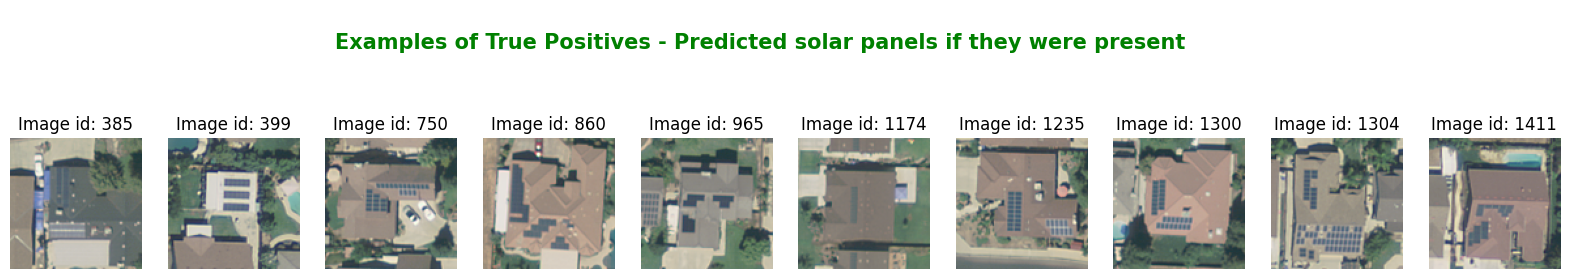

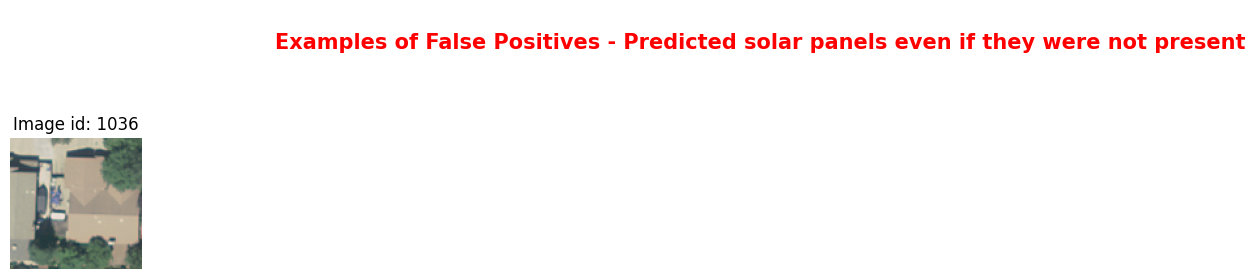

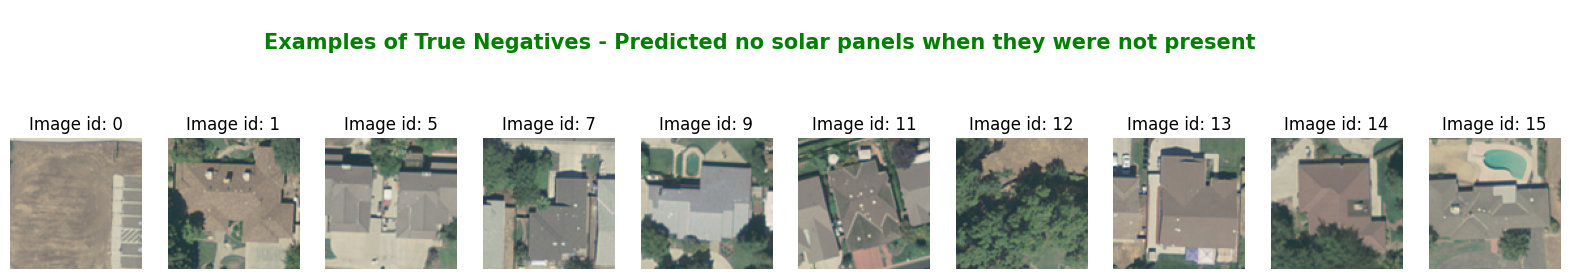

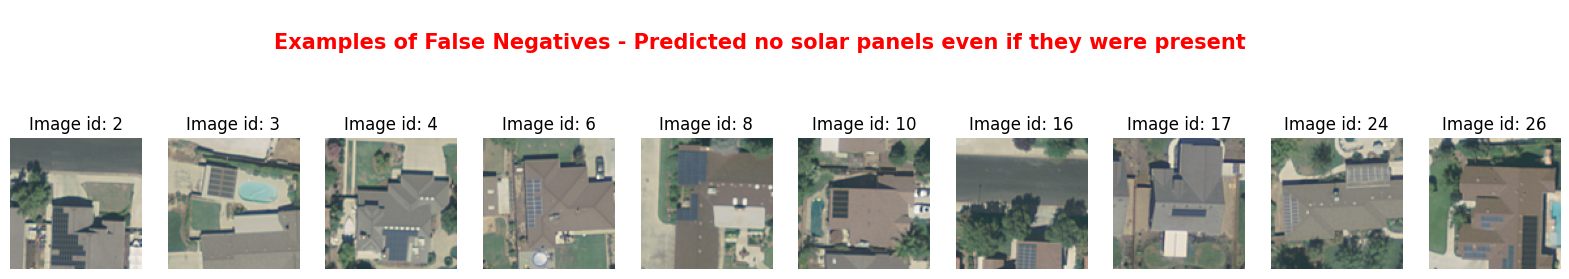

In [17]:
num_images = 10
show_images(tp, num_images, 'Examples of True Positives - Predicted solar panels if they were present', 'g')
show_images(fp, num_images, 'Examples of False Positives - Predicted solar panels even if they were not present', 'r')
show_images(tn, num_images, 'Examples of True Negatives - Predicted no solar panels when they were not present', 'g')
show_images(fn, num_images, 'Examples of False Negatives - Predicted no solar panels even if they were present', 'r')

# Model Evaluation & Results<a name ="h6"></a>

In [18]:
def plot_roc(y_true, y_pred_cnn):
    '''
    Plots ROC curves for the CNN models.
    '''
    plt.figure(figsize=(8, 8))


    fpr, tpr, _ = roc_curve(y_true, y_pred_cnn, pos_label=1)
    auc = roc_auc_score(y_true, y_pred_cnn)
    legend_string = 'CNN Model - AUC = {:0.3f}'.format(auc)
    plt.plot(fpr, tpr, color='red', label=legend_string)


    plt.plot([0, 1], [0, 1], '--', color='gray', label='Chance - AUC = 0.5')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()
    plt.title('ROC Curve', fontsize=10)
    pass

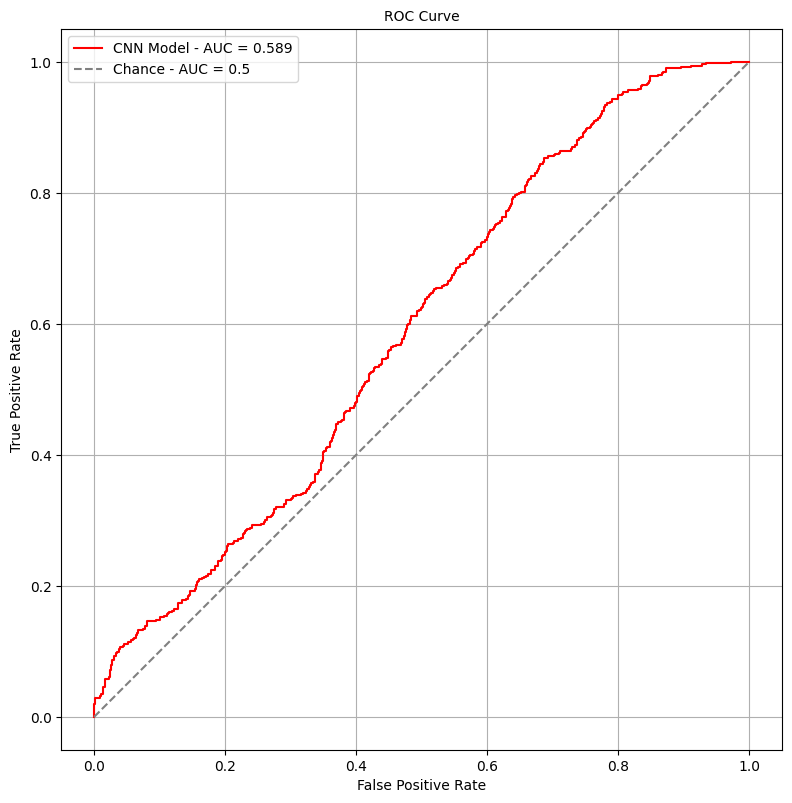

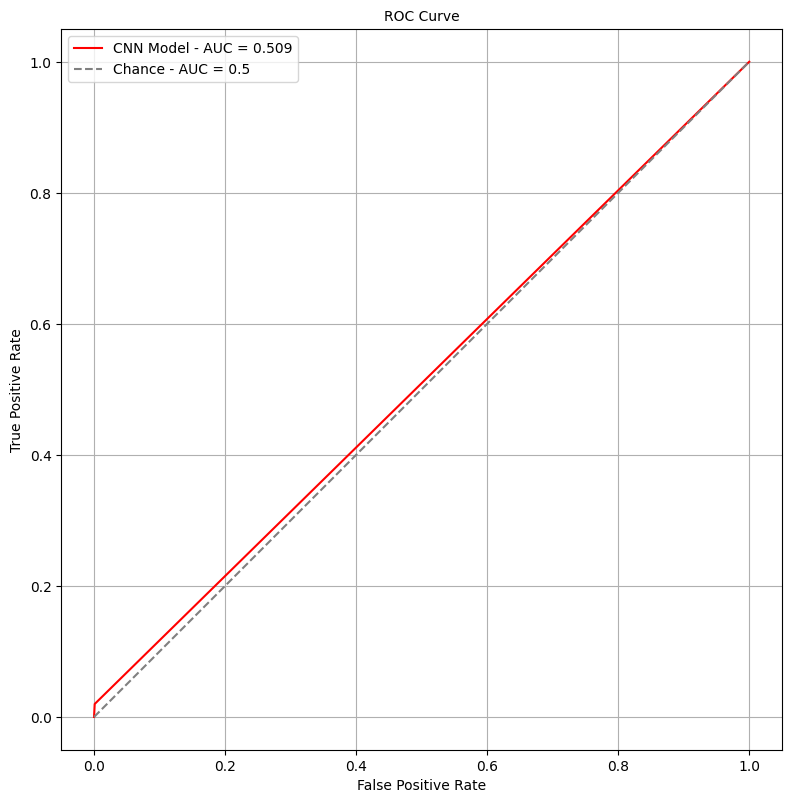

In [19]:
y_pred = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_prob]
plot_roc(y,  cnn_y_hat_prob)
plot_roc(y, y_pred)

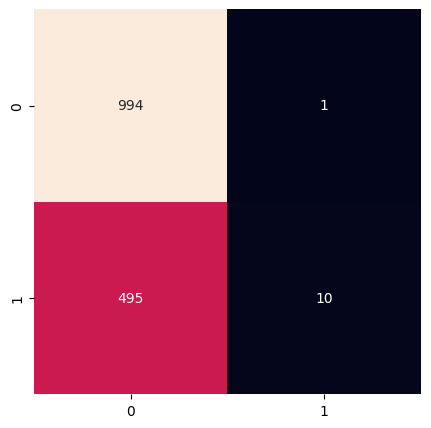

In [20]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y, y_pred), annot = True, cbar = False, fmt='.0f')
plt.show()